<a href="https://colab.research.google.com/github/shayan-kousha/Normalizing-Flows/blob/master/Models/Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Normalizing Flows - Basics**
(This file is copied from https://github.com/saeed1262)









## **Change of Variable Formula**
The main idea behind normalizing flows is based on the Change of Variable Formula

Let $\mathbf{Z} \in \mathbb{R}^{D}$ be a random variable with tractable probability density function $p_{\mathbf{Z}}: \mathbb{R}^{D} \rightarrow \mathbb{R}$.

Let $\mathbf{X}=\mathbf{g}(\mathbf{Z})$ be a function of $\mathbf{Z}$ where $\mathbf{g}$ is invertible and we call its inverse function $\mathbf{f}$.

Then the probability of desity function of $\mathbf{X}$ can be computed using change of variable formula:

$ p_{\mathbf{X}}(\mathbf{x}) =p_{\mathbf{Z}}(\mathbf{f}(\mathbf{x}))|\operatorname{det} \operatorname{Df}(\mathbf{x})| =p_{\mathbf{Z}}(\mathbf{f}(\mathbf{x}))|\operatorname{det} \operatorname{Dg}(\mathbf{f}(\mathbf{x}))|^{-1} $

Log-likelihood:

$ \log p_{\mathbf{X}}(\mathbf{x}) = \log p_{\mathbf{Z}}(\mathbf{f}(\mathbf{x})) - \log |\operatorname{det} \operatorname{Dg}(\mathbf{f}(\mathbf{x}))|^{-1} $

where $\operatorname{Df}(\mathbf{x})=\frac{\partial \mathbf{f}}{\partial \mathbf{x}}$ is the Jacobian of $\mathbf{f}$ and $\operatorname{Dg}(\mathbf{z})=\frac{\partial \mathbf{g}}{\partial \mathbf{z}}$ is the Jacobian of $\mathbf{g}$.

*   Function $\mathbf{g}$, called generator, "pushes forward" the base density $p_{\mathbf{Z}}$ to the more complex density $p_{\mathbf{X}}$. The direction from base density to the complex density is called generative direction.
*   Function $\mathbf{f}$, called normalizer, transforms the complex density $p_{\mathbf{X}}$ to the simple base density $p_{\mathbf{Z}}$ in the normalizing direction




## **Normalizing Flows**
* Normalizing Flows are a sequence of bijections which are easy to
  1. compute
  2. invert
  3. calculate the determinant of their Jacobian

let $\mathbf{g}_{1}, \ldots, \mathbf{g}_{N}$ be a set of $N$ bijective functions and $\mathbf{g}=\mathbf{g}_{N} \circ \mathbf{g}_{N-1} \circ \cdots \circ \mathbf{g}_{1}$ the composition of these functions. The $g$ is also a bijections with inverse:

$\mathbf{f}=\mathbf{f}_{1} \circ \cdots \circ \mathbf{f}_{N-1} \circ \mathbf{f}_{N}$

and the determinant of Jacobian:

$\operatorname{det} \operatorname{Df}(\mathbf{y})=\prod_{i=1}^{N} \operatorname{det} \operatorname{Df}_{i}\left(\mathbf{x}_{i}\right)$

A set of nonlinear bijective functions can be composed to construct successively more complicated functions.

* The interface class containing the methods for computing forward direction, backward direction, and the log determinant of Jacobian of a bijection is called a **bijector**

A pytorch bijector class can be similar to the following one
```
class Bijector(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # commputing the forward direction
        return z

    def inverse(self, z):
        # Computing the backward direction
        return x

    def log_abs_det_jacobian(self, x, z):
        # Computing the log absolute value of the determinant of Jacobian
        return ladj
```

or

```
class Bijector(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # commputing the forward direction
        return z, forward_ladj

    def inverse(self, z):
        # Computing the backward direction
        return x, backward_ladj
```


## **Learning Process**
Given: dataset $\mathcal{D}=\left\{\mathbf{y}^{(i)}\right\}_{i=1}^{M}$

Choose a base distribution with parameters $\phi$

Perform Maximum Log-Likelihood on

$\begin{equation} \log p(\mathcal{D} | \Theta) =\sum_{i=1}^{M} \log p_{\mathbf{Y}}\left(\mathbf{y}^{(i)} | \Theta\right) \\ =\sum_{i=1}^{M} \log p_{\mathbf{Z}}\left(\mathbf{f}\left(\mathbf{y}^{(i)} | \theta\right) | \phi\right)+\log \left|\operatorname{det} \operatorname{Df}\left(\mathbf{y}_{i} | \theta\right)\right| \end{equation}$

where $\theta$ is the set of normalizing flows parameters and $\Theta=(\theta, \phi)$ is the set of parameters to bo optimized


## **Datasets**
Download preprocessed UCI Datasets here : https://zenodo.org/record/1161203#.Wmtf_XVl8eN

### **Sample Code**


In [19]:
import os
import math
import gzip
import pickle
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

!pip install ipdb

# IPython extension to reload modules before executing user code. https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

root = "./drive/My Drive/data/"

  Created wheel for ipdb: filename=ipdb-0.13.2-cp36-none-any.whl size=10522 sha256=7ebf03ad6b66a987d159f6d004f440b38c01a7e77f4e35eae10e84bc86519dc5
  Stored in directory: /root/.cache/pip/wheels/60/c2/15/793365e3c9318c46ba914263740d90f1fe67f544b979141ce4
Successfully built ipdb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### **Helper Functions**

In [0]:
# Utils

def plot_dist_sample(data, ax, ranges):
  '''
  what does this function do #TODO
  '''
  ax.scatter(
    data[:, 0].data.cpu().numpy(), data[:, 1].data.cpu().numpy(), s=20, alpha=0.4
  )
  # format
  (xmin, xmax), (ymin, ymax) = ranges
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)
  ax.set_xticks([xmin, xmax])
  ax.set_yticks([ymin, ymax])

def image_grid(images):
  """Return a 10*10 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10, 10))
  for i in range(100):
    # Start next subplot.
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap="gray", interpolation=None)

In [0]:
# Data loader
def fetch_dataloaders(
    dataset_name,
    batch_size,
    device,
    flip_toy_var_order=False,
    toy_train_size=25000,
    toy_test_size=5000,
):

    # grab datasets
    import ipdb; ipdb.set_trace()
    if dataset_name in ["MNIST"]:
        dataset = MNIST()

        # join train and val data again
        train_x = np.concatenate((dataset.trn.x, dataset.val.x), axis=0).astype(
            np.float32
        )
        train_y = np.concatenate((dataset.trn.y, dataset.val.y), axis=0).astype(
            np.float32
        )
        # construct datasets
        train_dataset = TensorDataset(
            torch.from_numpy(train_x), torch.from_numpy(train_y)
        )
        test_dataset = TensorDataset(
            torch.from_numpy(dataset.tst.x.astype(np.float32)),
            torch.from_numpy(dataset.tst.y.astype(np.float32)),
        )

        input_dims = dataset.n_dims
        label_size = 10
        lam = dataset.alpha

    elif dataset_name in ["TOY"]:  # use own constructors
        train_dataset = TOY(toy_train_size, flip_toy_var_order)
        test_dataset = TOY(toy_test_size, flip_toy_var_order)
        input_dims = train_dataset.input_size
        label_size = train_dataset.label_size
        lam = None                        
    else:
        raise ValueError("Unrecognized dataset.")

    # keep input dims, input size and label size
    train_dataset.input_dims = input_dims
    train_dataset.input_size = int(np.prod(input_dims))
    train_dataset.label_size = label_size
    train_dataset.lam = lam

    test_dataset.input_dims = input_dims
    test_dataset.input_size = int(np.prod(input_dims))
    test_dataset.label_size = label_size
    test_dataset.lam = lam

    # construct dataloaders
    kwargs = {"num_workers": 4, "pin_memory": True} if device.type == "cuda" else {}

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **kwargs)

    return train_loader, test_loader

In [0]:
# Dataset Util

def one_hot_encode(labels, n_labels):
    """
    Transforms numeric labels to 1-hot encoded labels. Assumes numeric labels are in the range 0, 1, ..., n_labels-1.
    """

    assert np.min(labels) >= 0 and np.max(labels) < n_labels

    y = np.zeros([labels.size, n_labels])
    y[range(labels.size), labels] = 1

    return y


def logit(x):
    """
    Elementwise logit (inverse logistic sigmoid).
    :param x: numpy array
    :return: numpy array
    """
    return np.log(x / (1.0 - x))

In [0]:
# MNIST loader
class MNIST:
    """
    The MNIST dataset of handwritten digits.
    """

    alpha = 1.0e-6

    class Data:
        """
        Constructs the dataset.
        """

        def __init__(self, data, logit, dequantize, rng):

            x = (
                self._dequantize(data[0], rng) if dequantize else data[0]
            )  # dequantize pixels
            self.x = self._logit_transform(x) if logit else x  # logit
            self.labels = data[1]  # numeric labels
            self.y = one_hot_encode(self.labels, 10)  # 1-hot encoded labels
            self.N = self.x.shape[0]  # number of datapoints

        @staticmethod
        def _dequantize(x, rng):
            """
            Adds noise to pixels to dequantize them.
            """
            return x + rng.rand(*x.shape) / 256.0

        @staticmethod
        def _logit_transform(x):
            """
            Transforms pixel values with logit to be unconstrained.
            """
            return logit(MNIST.alpha + (1 - 2 * MNIST.alpha) * x)

    def __init__(self, logit=True, dequantize=True):

        # load dataset
        f = gzip.open(root + "mnist/mnist.pkl.gz", "rb")
        trn, val, tst = pickle.load(f, encoding="latin1")
        f.close()

        rng = np.random.RandomState(42)
        self.trn = self.Data(trn, logit, dequantize, rng)
        self.val = self.Data(val, logit, dequantize, rng)
        self.tst = self.Data(tst, logit, dequantize, rng)

        im_dim = int(np.sqrt(self.trn.x.shape[1]))
        self.n_dims = (1, im_dim, im_dim)
        self.n_labels = self.trn.y.shape[1]
        self.image_size = [im_dim, im_dim]

In [0]:
import torch
import torch.distributions as D
from torch.utils.data import Dataset

class ToyDistribution(D.Distribution):
    def __init__(self, flip_var_order):
        super().__init__()
        self.flip_var_order = flip_var_order
        self.p_x2 = D.Normal(0, 4)
        self.p_x1 = lambda x2: D.Normal(0.25 * x2 ** 2, 1)

    def rsample(self, sample_shape=torch.Size()):
        x2 = self.p_x2.sample(sample_shape)
        x1 = self.p_x1(x2).sample()
        if self.flip_var_order:
            return torch.stack((x2, x1), dim=-1).squeeze()
        else:
            return torch.stack((x1, x2), dim=-1).squeeze()

class TOY(Dataset):
    def __init__(self, dataset_size=25000, flip_var_order=False):
        self.input_size = 2
        self.label_size = 1
        self.dataset_size = dataset_size
        self.base_dist = ToyDistribution(flip_var_order)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, i):
        return self.base_dist.sample(), torch.zeros(self.label_size)

#### **Code**


In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
dataset_name = "TOY"
train_dl, _ = fetch_dataloaders(dataset_name=dataset_name, 
                                batch_size=1000, 
                                device=device, 
                                flip_toy_var_order=False, 
                                toy_train_size=25000, 
                                toy_test_size=100)

torch.Size([1000, 2])


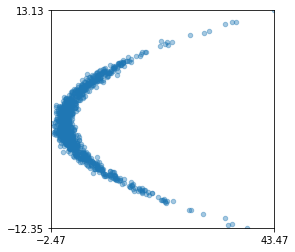

In [16]:
sample_batch = next(iter(train_dl))
print(sample_batch[0].shape)
fig, ax = plt.subplots(figsize=(4,4))
xmin, xmax = sample_batch[0].min(dim=0)[0][0], sample_batch[0].max(dim=0)[0][0]
ymin, ymax = sample_batch[0].min(dim=0)[0][1], sample_batch[0].max(dim=0)[0][1]
plot_dist_sample(sample_batch[0], ax, [[xmin, xmax],[ymin, ymax]])

In [0]:
dataset_name = "MNIST"
train_dl, _ = fetch_dataloaders(dataset_name=dataset_name, 
                                batch_size=1000, 
                                device=device, 
                                flip_toy_var_order=False, 
                                toy_train_size=25000, 
                                toy_test_size=100)

> <ipython-input-17-68b1869a257e>(13)fetch_dataloaders()
     12     import ipdb; ipdb.set_trace()
---> 13     if dataset_name in ["MNIST"]:
     14         dataset = MNIST()

ipdb> dataset_name
'MNIST'
ipdb> l
      8     toy_test_size=5000,
      9 ):
     10 
     11     # grab datasets
     12     import ipdb; ipdb.set_trace()
---> 13     if dataset_name in ["MNIST"]:
     14         dataset = MNIST()
     15 
     16         # join train and val data again
     17         train_x = np.concatenate((dataset.trn.x, dataset.val.x), axis=0).astype(
     18             np.float32

ipdb> n
> <ipython-input-17-68b1869a257e>(14)fetch_dataloaders()
     13     if dataset_name in ["MNIST"]:
---> 14         dataset = MNIST()
     15 

ipdb> n
> <ipython-input-17-68b1869a257e>(17)fetch_dataloaders()
     16         # join train and val data again
---> 17         train_x = np.concatenate((dataset.trn.x, dataset.val.x), axis=0).astype(
     18             np.float32

ipdb> dataset
ipdb> dataset.

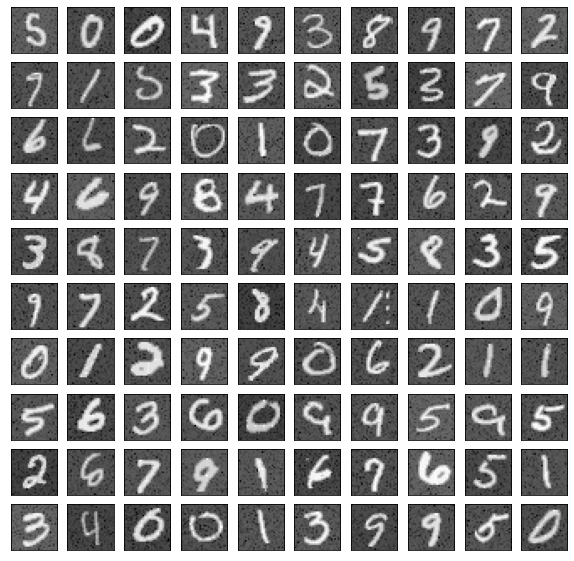

In [13]:
sample_batch = next(iter(train_dl))
image_grid(sample_batch[0][0:100].view(100,28,28))